In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import re
from sqlalchemy import create_engine


## Collegamento a un database PostgreSQL da Python
#Parametri di connessione (modifica con i tuoi dati)
user = 'postgres'
password = '18102001'
host = 'localhost'
port = '5433'
database = 'Plants'

# Stringa di connessione
conn_str = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}'

# Crea l'engine SQLAlchemy
engine = create_engine(conn_str)

# Esempio: leggi una tabella in un DataFrame pandas
# Sostituisci 'nome_tabella' con il nome della tabella che vuoi importare
try:
    df = pd.read_sql("SELECT t1.id_country, SUM (t1.capacity_mw) AS CAPACITY, SUM (t2.generation_2013_gwh) AS GEN13, SUM (t2.generation_2014_gwh) AS GEN14, SUM (t2.generation_2015_gwh) AS GEN15, SUM (t2.generation_2016_gwh) AS GEN16, SUM (t2.generation_2017_gwh) AS GEN17, SUM (t2.generation_2018_gwh) AS GEN18, SUM (t2.generation_2019_gwh) AS GEN19 FROM plant AS t1 INNER JOIN energy AS t2 ON t1.id_plant = t2.id_plant  GROUP BY t1.id_country", engine)
    print(df.head())
except Exception as e:
    print("Errore di connessione o query:", e)
#</VSCode.Cell>
# leggi il CSV (low_memory=False per evitare avvisi su tipi misti)
#df = pd.read_csv('global_power_plant_database.csv', low_memory=False)

#print(df.head())

  id_country  capacity     gen13  gen14     gen15     gen16     gen17  gen18  \
0        PRY   8760.00       NaN    NaN       NaN       NaN       NaN    NaN   
1        MDG    359.93       NaN    NaN       NaN       NaN       NaN    NaN   
2        TZA    994.50       NaN    NaN       NaN       NaN       NaN    NaN   
3        NLD  16993.69       NaN    NaN  41355.45  58612.52  34031.85    NaN   
4        VEN  31096.00  120004.0    NaN       NaN       NaN       NaN    NaN   

   gen19  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN  


In [ ]:

# leggi il CSV (low_memory=False per evitare avvisi su tipi misti)
df = pd.read_csv('global_power_plant_database.csv', low_memory=False)

#* voglio creare un dataframe dove aggreghiamo i records per country_long, calcolando la somma di capacity_mw e la somma di generation_gwh_2013-2016, quando una somma viene calcolata, se un valore è NaN viene visualizzato come naN nella somma finale

print("\n*** Aggregazione per Country ***")
df = df.groupby('country').agg({
    'capacity_mw': 'sum',
    'generation_gwh_2013': 'sum',
    'generation_gwh_2014': 'sum',
    'generation_gwh_2015': 'sum',
    'generation_gwh_2016': 'sum',  
    'generation_gwh_2017': 'sum',
    'generation_gwh_2018': 'sum',
    'generation_gwh_2019': 'sum'
}).reset_index()       

print(df[df['country'] == 'USA'])


In [ ]:

#PREPROCESSING - gestione dei valori mancanti

#*voglio sostituire i valori 0 con NaN nelle colonne  generation_gwh_2013-2019*
df[['gen13', 'gen14', 'gen15', 'gen16','gen17', 'gen18', 'gen19']] = df[['gen13', 'gen14', 'gen15', 'gen16',
    'gen17', 'gen18', 'gen19']].replace(0, np.nan)    

#*voglio dividere la capacity di ogni riga per 1000 per avere valori più gestibili*
df['capacity'] = df['capacity'] / 1000

#*voglio cambiare il nome di capacity_mw in capacity_gw*
#df.rename(columns={'capacity_mw': 'capacity_gw'}, inplace=True)

#print(df[df['country'] == 'USA'])

#calcoliamo le ore medie di generazione per ogni ANNO, dividendo la somma totale di generation_gwh per la somma totale di capacity_gw (considerando solo le righe dove generation_gwh non è NaN)

tot13= sum(df['gen13'].dropna())
cap13 = df.loc[df['gen13'].notna(), 'capacity'].sum()
oremedie13 = tot13 / cap13

tot14= sum(df['gen14'].dropna())
cap14 = df.loc[df['gen14'].notna(), 'capacity'].sum()
oremedie14 = tot14 / cap14

tot15= sum(df['gen15'].dropna())
cap15 = df.loc[df['gen15'].notna(), 'capacity'].sum()
oremedie15 = tot15 / cap15

tot16= sum(df['gen16'].dropna())
cap16 = df.loc[df['gen16'].notna(), 'capacity'].sum()
oremedie16 = tot16 / cap16  

tot17= sum(df['gen17'].dropna())
cap17 = df.loc[df['gen17'].notna(), 'capacity'].sum()
oremedie17 = tot17 / cap17

tot18= sum(df['gen18'].dropna())
cap18 = df.loc[df['gen18'].notna(), 'capacity'].sum()
oremedie18 = tot18 / cap18

tot19= sum(df['gen19'].dropna())
cap19 = df.loc[df['gen19'].notna(), 'capacity'].sum()
oremedie19 = tot19 / cap19

#*voglio sostituire i valori NaN in generation_gwh_2013-2019 con la capacity_gw moltiplicata per le ore medie di generazione calcolate per ogni anno*
df.loc[df['gen13'].isna(), 'gen13'] = df.loc[df['gen13'].isna(), 'capacity'] * oremedie13  
df.loc[df['gen14'].isna(), 'gen14'] = df.loc[df['gen14'].isna(), 'capacity'] * oremedie14  
df.loc[df['gen15'].isna(), 'gen15'] = df.loc[df['gen15'].isna(), 'capacity'] * oremedie15  
df.loc[df['gen16'].isna(), 'gen16'] = df.loc[df['gen16'].isna(), 'capacity'] * oremedie16  
df.loc[df['gen17'].isna(), 'gen17'] = df.loc[df['gen17'].isna(), 'capacity'] * oremedie17  
df.loc[df['gen18'].isna(), 'gen18'] = df.loc[df['gen18'].isna(), 'capacity'] * oremedie18  
df.loc[df['gen19'].isna(), 'gen19'] = df.loc[df['gen19'].isna(), 'capacity'] * oremedie19

#print(df[df['id_country'] == 'USA'])


   id_country  capacity       gen13       gen14       gen15       gen16  \
86        USA  1.204638  3474742.88  3456615.85  3573787.15  3512830.43   

         gen17       gen18       gen19  
86  3529345.21  3634346.78  4094670.61  


In [4]:
#MODELLI

features = ['capacity','gen13','gen14','gen15','gen16']
target1 = 'gen17'
target2 = 'gen18'
target3 = 'gen19'
data = df[features]
data1 = df[[target1]]
data2 = df[[target2]]
data3 = df[[target3]]

# combino feature e target e rimuovo righe con NaN nelle colonne selezionate
combined1 = pd.concat([data, data1], axis=1)
combined2 = pd.concat([data, data2], axis=1)
combined3 = pd.concat([data, data3], axis=1)

#print('combined2:')
#print(combined2)

n_before1 = combined1.shape[0]
n_before2 = combined2.shape[0]
n_before3 = combined3.shape[0]

# rimuovo righe con NaN nelle colonne selezionate (dropna)
combined_clean1 = combined1.dropna()
combined_clean2 = combined2.dropna()
combined_clean3 = combined3.dropna()

n_after1 = combined_clean1.shape[0]
n_after2 = combined_clean2.shape[0]
n_after3 = combined_clean3.shape[0]

print(f"Rows before: {n_before1}, after dropna: {n_after1} (dropped {n_before1-n_after1})")
print(f"Rows before: {n_before2}, after dropna: {n_after2} (dropped {n_before2-n_after2})")
print(f"Rows before: {n_before3}, after dropna: {n_after3} (dropped {n_before3-n_after3})")

# estraggo X e y da dati puliti
x1 = combined_clean1[features].values
y1 = combined_clean1[target1].values
x2 = combined_clean2[features].values
y2 = combined_clean2[target2].values
x3 = combined_clean3[features].values
y3 = combined_clean3[target3].values

print('X1 shape:', x1.shape, 'y1 shape:', y1.shape)
print('X2 shape:', x2.shape, 'y2 shape:', y2.shape)
print('X3 shape:', x3.shape, 'y3 shape:', y3.shape)

if x1.shape[0] == 0:
    raise ValueError('No rows left after dropping NaN in dataset 1. Consider imputing missing values instead.')
if x2.shape[0] == 0:
    raise ValueError('No rows left after dropping NaN in dataset 2. Consider imputing missing values instead.')
if x3.shape[0] == 0:
    raise ValueError('No rows left after dropping NaN in dataset 3. Consider imputing missing values instead.')


X_train1, X_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size=0.2, shuffle=False)
X_train2, X_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, shuffle=False)
X_train3, X_test3, y_train3, y_test3 = train_test_split(x3, y3, test_size=0.2, shuffle=False)

# converti y in vettore 1D per evitare DataConversionWarning
y_train1 = y_train1.ravel()
y_test1 = y_test1.ravel()
y_train2 = y_train2.ravel()
y_test2 = y_test2.ravel()
y_train3 = y_train3.ravel()
y_test3 = y_test3.ravel()

print("*** Linear Regression 1 ***")
clf = LinearRegression()
clf.fit(X_train1, y_train1)
y_pred = clf.predict(X_test1)
print('MAE:', mean_absolute_error(y_test1, y_pred))

print("*** Random Forest 1 ***")
clf = RandomForestRegressor(random_state=42)
clf.fit(X_train1, y_train1)
y_pred = clf.predict(X_test1)
print('MAE:', mean_absolute_error(y_test1, y_pred))

print("*** KNN Regression 1 ***")
clf = KNeighborsRegressor(n_neighbors=20)
clf.fit(X_train1, y_train1)
y_pred = clf.predict(X_test1)
print('MAE:', mean_absolute_error(y_test1, y_pred))

print("*** Linear Regression 2 ***")
clf = LinearRegression()
clf.fit(X_train2, y_train2)
y_pred = clf.predict(X_test2)
print('MAE:', mean_absolute_error(y_test2, y_pred))

print("*** Random Forest 2 ***")
clf = RandomForestRegressor(random_state=42)
clf.fit(X_train2, y_train2)
y_pred = clf.predict(X_test2)
print('MAE:', mean_absolute_error(y_test2, y_pred))

print("*** KNN Regression 2 ***")
clf = KNeighborsRegressor(n_neighbors=20)
clf.fit(X_train2, y_train2)
y_pred = clf.predict(X_test2)
print('MAE:', mean_absolute_error(y_test2, y_pred))

print("*** Linear Regression 3 ***")
clf = LinearRegression()
clf.fit(X_train3, y_train3)
y_pred = clf.predict(X_test3)
print('MAE:', mean_absolute_error(y_test3, y_pred))


print("*** Random Forest 3 ***")
clf = RandomForestRegressor(random_state=42)
clf.fit(X_train3, y_train3)
y_pred = clf.predict(X_test3)
print('MAE:', mean_absolute_error(y_test3, y_pred))

print("*** KNN Regression 3 ***")
clf = KNeighborsRegressor(n_neighbors=20)
clf.fit(X_train3, y_train3)
y_pred = clf.predict(X_test3)
print('MAE:', mean_absolute_error(y_test3, y_pred))


Rows before: 167, after dropna: 167 (dropped 0)
Rows before: 167, after dropna: 167 (dropped 0)
Rows before: 167, after dropna: 167 (dropped 0)
X1 shape: (167, 5) y1 shape: (167,)
X2 shape: (167, 5) y2 shape: (167,)
X3 shape: (167, 5) y3 shape: (167,)
*** Linear Regression 1 ***
MAE: 971.5725806101121
*** Random Forest 1 ***
MAE: 7459.971354582793
*** KNN Regression 1 ***
MAE: 37250.71165426942
*** Linear Regression 2 ***
MAE: 657.9804148734922
*** Random Forest 2 ***
MAE: 7750.768246039537
*** KNN Regression 2 ***
MAE: 42162.74888175366
*** Linear Regression 3 ***
MAE: 8.468143833210086e-11
*** Random Forest 3 ***
MAE: 8758.633246721318
*** KNN Regression 3 ***
MAE: 45681.30712168462


      LinearRegression  RandomForest         KNN
year                                            
2017          971.5726     7459.9714  37250.7117
2018          657.9804     7750.7682  42162.7489
2019            0.0000     8758.6332  45681.3071


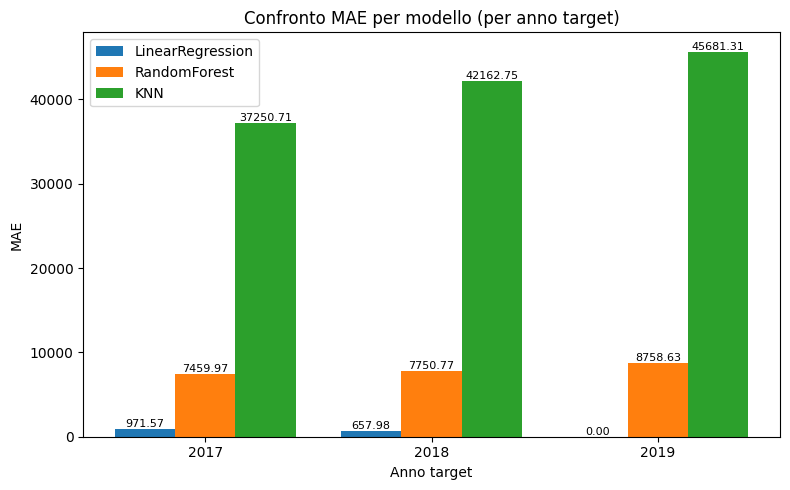

In [5]:
# confronto mae modelli su tutti i dataset disponibili (x-axis = anni target)

datasets = []  # lista di tuple (year_label, X_train, X_test, y_train, y_test)

# Preferisci usare split già calcolati se esistono (assumiamo dataset1->2017, dataset2->2018, dataset3->2019)
for i in (1,2,3,4,5):
    xt_name = f'X_train{i}'
    xtest_name = f'X_test{i}'
    ytrain_name = f'y_train{i}'
    ytest_name = f'y_test{i}'
    if all(n in globals() for n in (xt_name, xtest_name, ytrain_name, ytest_name)):
        year_label = str(2016 + i)
        datasets.append((year_label, globals()[xt_name], globals()[xtest_name], globals()[ytrain_name], globals()[ytest_name]))
        continue
    # fallback: ricostruisci da combined_clean{i} se esiste (estrai anno dal nome target)
    combined_name = f'combined_clean{i}'
    if combined_name in globals():
        combined = globals()[combined_name].copy()
        cols = combined.columns.tolist()
        target_col = cols[-1]
        m = re.search(r'(\d{4})', target_col)
        year_label = m.group(1) if m else f'year{i}'
        features = cols[:-1]
        X = combined[features].values
        y = combined[target_col].values.ravel()
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, shuffle=False)
        datasets.append((year_label, X_tr, X_te, y_tr, y_te))

if not datasets:
    raise RuntimeError("Nessun dataset di training/test trovato o ricostruibile: esegui prima le celle che preparano combined_clean* o X_train/X_test.")

results = []
for year_label, X_tr, X_te, y_tr, y_te in datasets:
    lr = LinearRegression(); lr.fit(X_tr, y_tr); y_lr = lr.predict(X_te); mae_lr = mean_absolute_error(y_te, y_lr)
    rf = RandomForestRegressor(random_state=42); rf.fit(X_tr, y_tr); y_rf = rf.predict(X_te); mae_rf = mean_absolute_error(y_te, y_rf)
    knn = KNeighborsRegressor(n_neighbors=20); knn.fit(X_tr, y_tr); y_knn = knn.predict(X_te); mae_knn = mean_absolute_error(y_te, y_knn)
    results.append({'year': year_label, 'LinearRegression': mae_lr, 'RandomForest': mae_rf, 'KNN': mae_knn})

df_results = pd.DataFrame(results).set_index('year').sort_index()
print(df_results.round(4))

# Grafico a barre raggruppate con anni sull'asse x
models = df_results.columns.tolist()
n_models = len(models)
x = np.arange(len(df_results))
width = 0.8 / n_models

fig, ax = plt.subplots(figsize=(max(8, len(df_results)*1.0), 5))
colors = plt.cm.tab10(np.arange(n_models))
for i, m in enumerate(models):
    ax.bar(x + (i - (n_models-1)/2)*width, df_results[m].values, width=width, label=m, color=colors[i])

ax.set_xticks(x)
ax.set_xticklabels(df_results.index.tolist(), rotation=0)  # anni come etichette
ax.set_xlabel('Anno target')
ax.set_ylabel('MAE')
ax.set_title('Confronto MAE per modello (per anno target)')
ax.legend()
for i in range(len(df_results)):
    for j in range(n_models):
        v = df_results.iloc[i, j]
        ax.text(x[i] + (j - (n_models-1)/2)*width, v, f'{v:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()